# Understand GPU Memory Usage when Training Language Models

## Introduction

When fine-tuning large machine learning models, it's crucial to grasp the details of GPU memory consumption to optimize the training process and avert the frequently encountered "Cuda out of memory" error. The substantial memory demand primarily arises from the requirement to store model parameters, gradients, and intermediate activations throughout the forward and backward passes of the training sequence. 

The dreaded "Cuda out of memory" error manifests when the GPU's available memory fails to meet the model's computational demands. Various factors can precipitate this issue, including training with excessively large batch sizes, employing a model architecture that surpasses the GPU's memory capacity, or neglecting to implement memory optimization techniques such as gradient checkpointing or mixed precision training. These practices are crucial for managing the extensive memory requirements of large models.

Understanding the dynamics of GPU memory consumption is pivotal for the efficient training of models. This notebook is designed to shed light on the nuances of GPU memory usage using the example of the fine-tuning process of transformer-based models, in this case the BERT-large model. It aims to elucidate the causes behind the "Cuda out of memory" error and suggest when it might occur, providing valuable insights for optimizing model training and preventing memory-related setbacks.

I run all tests in this notebook on an Nvidia RTX 3090 GPU with 24 GiB of memory. You can use the script to get the insights to your own GPU.

## Preliminary Work

We start with all needed package imports:

In [1]:
import matplotlib.patches as patches
import numpy as np
from datasets import Dataset
import torch
from torch.profiler import ProfilerActivity
from transformers import AutoModelForSequenceClassification
import gc
from pynvml import (nvmlInit,
                    nvmlDeviceGetHandleByIndex,
                    nvmlDeviceGetMemoryInfo)
from transformers import TrainingArguments
from torch.utils.data.dataloader import DataLoader
from torch.optim import AdamW
import pandas as pd
import matplotlib.pyplot as plt

We first establish a function designed to monitor and report on the GPU's memory usage. This function is critical for understanding how different phases of the training process affect memory allocation and consumption on the GPU. 
It specifically prints out three key items to provide a comprehensive overview of the current memory landscape:

1. **GPU Memory Occupied**:<br>This metric reveals the actual amount of memory currently in use on the GPU. It's an essential indicator of how much memory is being utilized by all processes running on the GPU, offering insight into the available capacity for additional computations.<br>
<br>
2. **Reserved GPU Memory by Torch**: <br>This figure represents the memory that has been earmarked by the PyTorch framework for its operations but is not currently occupied. Although this portion of memory is not actively being used, it is set aside exclusively for PyTorch, meaning it cannot be accessed by other tools or applications. This reservation is crucial for PyTorch to efficiently manage its memory needs, ensuring there's a buffer for future data items or computations without the need to constantly request more memory from the GPU.<br>
<br>
3. **Allocated GPU Memory by Torch**: <br>This measurement indicates the amount of GPU memory directly occupied by PyTorch tensors at any given moment. It provides a clear view of how much memory PyTorch is actively using, which is crucial for understanding the memory footprint of your model's tensors and the impact of operations such as forward and backward passes.<br>


It is important to recognize that there are multiple systems for defining units of digital information, which can lead to confusion. Specifically, two main systems exist:

- **Units based on powers of 10:** For example, 1 kilobyte (kB) equals 1,000 bytes.
- **Units based on powers of 2:** For example, 1 kibibyte (KiB) equals 1,024 bytes, or 2<sup>10</sup>.

The distinction between these systems is critical, yet confusion often arises. For example, the term "kB" (a power of 10 unit) is frequently used when the intended meaning is actually "KiB" (a power of 2 unit). This discrepancy is evident in various applications, such as the Windows Task Manager and Nvidia's specifications for their GPUs. Example: The GPU I use is the Nvidia RTX 3090, which has 24 GiB of memory, even though Nvidia reports it as having 24 GB.
Note: You can verify that by running the command `torch.cuda.mem_get_info()[1]`, which returns the total GPU memory for a given device.

To maintain consistency and clarity within this script, I have chosen to use the power of 2 notation (e.g., KiB, MiB, GiB). This choice aims to avoid the common confusion and ensure that the memory units are accurately represented. For a more comprehensive discussion on this topic and the prevalent confusion surrounding these units, you can refer to [this article on Wikipedia](https://en.wikipedia.org/wiki/Byte).

In [2]:
def print_gpu_utilization():
    gc.collect()
    torch.cuda.empty_cache()
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print("############################################")
    print("GPU memory statistics")
    print("GPU memory occupied: "+f"{info.used/1024**2:.2f} MiB".rjust(23))
    print("Reserved GPU memory by torch: " +
          f"{torch.cuda.memory_reserved()/1024**2:.2f} MiB".rjust(14))
    print("Allocated GPU memory by torch: " +
          f"{torch.cuda.memory_allocated()/1024**2:.2f} MiB".rjust(13))
    print("############################################\n")

Let's have a look on the GPU summary before we start using pytorch:

In [3]:
print_gpu_utilization()

############################################
GPU memory statistics
GPU memory occupied:              895.04 MiB
Reserved GPU memory by torch:       0.00 MiB
Allocated GPU memory by torch:      0.00 MiB
############################################



We see that there is already some GPU memory occupied before using pytorch at all. This is due to GPU drivers and some other background processes. Let's store that default GPU occupation to the variable `default_gpu_occupation` to be able to distinguish it later from the GPU memory occupied by pytorch:

In [4]:
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
default_gpu_occupation = info.used

When using pytorch the first time, additional ~300 MiB of GPU memory will be occupied. This is due to the CUDA context, that contains the driver, CUDA kernels etc. See [here](https://github.com/pytorch/pytorch/issues/107667) for a more detailed discussion. Let's add this occupied memory to `default_gpu_occupation` too:

In [5]:
default_gpu_occupation += 300 * 1024**2

## Theoretical considerations

Next, we will estimate the total GPU memory consumption when fine-tuning a BERT-large model. In general, there are three main drivers that occupy memory during fine-tuning:
1. The model weights
2. The feed-forward tensors, which are needed for future gradient calculations
3. The gradients of the model weights

We will estimate the GPU memory of all these three components.

However, we start by defining the two main parameters that control the final GPU memory consumption, e.g. the batch size and and the maximum sequence length. Additionally, we load the BERT model:

In [6]:
# Define main parameters for this script
batch_size = 4
seq_len = 512
mdl = AutoModelForSequenceClassification.from_pretrained("bert-large-uncased")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Estimating GPU Memory Usage for Model Weights

To accurately assess the amount of GPU memory utilized by the BERT-large model's weight tensors, it's essential to begin by examining the floating-point data type used for the weights. This examination will clarify the number of bytes required to store a single numerical value within the model's architecture:

In [7]:
# %% Inspect dtype of BERT
dtype = mdl.bert.embeddings.word_embeddings.weight.dtype
print(f"\nDtype of bert weights: {dtype}")
element_size = mdl.bert.embeddings.word_embeddings.weight.element_size()
print(f"Number of bytes of single bert weight: {element_size}")
# Test if every model weight is of the same data type
for par in mdl.parameters():
    assert par.dtype == torch.float32


Dtype of bert weights: torch.float32
Number of bytes of single bert weight: 4


We see that all weights of the BERT model are of type `torch.float32` which occupy 4 bytes. To estimate the total expected memory usage of the model weights, we just have to multiply the number of single numerical values with 4 bytes:

In [8]:
# %% Get expected size of BERT weights
expected_memory_model_weights = 0
for par in mdl.parameters():
    expected_memory_model_weights += element_size * par.numel()
expected_memory_model_weights = expected_memory_model_weights

print(
    f"Expected GPU usage by storing model weigths: "
    f"{expected_memory_model_weights / 1024**2:.2f} MiB")

Expected GPU usage by storing model weigths: 1278.47 MiB


When we load the model weights onto the GPU, we're assuming an additional allocation of approximately 1278.47 MiB of storage space. This increase in memory usage is relatively small, especially when you consider the GPU's total available capacity of 24 GiB.

However, there's another aspect we have to consider: large PyTorch tensors can consume more GPU memory than initially anticipated (for reference, see [this discussion](https://discuss.pytorch.org/t/discrepancy-between-expected-and-actual-gpu-memory-usage-for-large-tensors/195049)).

This factor only becomes relevant for the BERT model when considering its embedding weight matrix, which has dimensions of 30522 x 1024. Given this significant size, it's crucial to examine the memory implications of this tensor more closely. First, we calculate the theoretical size as before:

In [9]:
word_embeddings_shape = mdl.bert.embeddings.word_embeddings.weight.shape
expected_size_word_embeddings = word_embeddings_shape[0] * \
    word_embeddings_shape[1] * element_size

Next, we check how much memory it actually consumes an we compare it to the expected memory:

In [10]:
print(
    f"Memory allocated to GPU before adding embedding weights: "
    f"{torch.cuda.memory_allocated() / 1024**2:.2f} MiB")
tmp = mdl.bert.embeddings.word_embeddings.weight.to("cuda")
allocated_memory_act = torch.cuda.memory_allocated()
print(
    f"Memory allocated to GPU after adding embedding weights: "
    f"{torch.cuda.memory_allocated() / 1024**2:.2f} MiB")
print(
    f"Expected memory allocated to GPU after adding embedding weights: "
    f"{expected_size_word_embeddings / 1024**2:.2f} MiB")

Memory allocated to GPU before adding embedding weights: 0.00 MiB
Memory allocated to GPU after adding embedding weights: 120.00 MiB
Expected memory allocated to GPU after adding embedding weights: 119.23 MiB


We noted a discrepancy of 770 KiB. We'll incorporate this difference into the `expected_memory_model_weights` variable. 

We'll proceed to unload these weights from the GPU. This step ensures that the coming analysis remains unaffected by previous steps.

In [11]:
additional_memory_word_embeddings = allocated_memory_act - \
    expected_size_word_embeddings
expected_memory_model_weights += additional_memory_word_embeddings

del tmp
gc.collect()
torch.cuda.empty_cache()

Now we are done with the estimation of the GPU memory usage of the model weights.

### Assessing GPU Memory Requirements for Feedforward Tensors

In the process of fine-tuning a BERT model, aside from estimating the model weights, it's essential to allocate GPU memory for the feedforward tensors as well. These tensors are critical for later computing the gradient tensors. It will become evident that the GPU memory consumption attributed to feedforward tensors significantly exceeds that of the model weights. This variance is influenced by factors such as the batch size and the maximum sequence length utilized during training.

To methodically evaluate this aspect, our initial step involves creating a function designed to estimate the number of elements for all feedforward tensors. This estimation will take into account the batch size, sequence length and the specific BERT model variant in use.

This is probably the most complicated function in this script, as there are many different layers when running a BERT model. I'll first introduce the different parts of that function before providing it. Note that I really only focus on the feedforward-tensors that are crucial for gradient calculation. 

Initially, it's imperative to gather all the essential hyperparameters associated with the BERT model, including its hidden layer sizes, intermediate sizes, and the number of hidden layers and attention heads:

In [12]:
hidden_size = mdl.config.hidden_size
intermediate_size = mdl.config.intermediate_size
num_hidden_layers = mdl.config.num_hidden_layers
num_attention_heads = mdl.config.num_attention_heads

print(f"Hidden size: {hidden_size}")
print(f"Intermediate size: {intermediate_size}")
print(f"# hidden layers: {num_hidden_layers}")
print(f"# attention heads: {num_attention_heads}")

Hidden size: 1024
Intermediate size: 4096
# hidden layers: 24
# attention heads: 16


Our analysis confirms that we are indeed working with a BERT-large model, characterized by its 24 hidden (or encoder) layers, 16 attention heads, and sizes of 1024 for hidden layers and 4096 for intermediate layers, respectively.

A BERT model requires three primary inputs: token IDs, token type IDs and attention masks, leading to a total input parameter count of `3 * batch_size * seq_len`. This constitutes the initial set of feedforward tensors to be allocated on GPU memory. Note that we provide only the token IDs in this script, the rest is initialized automatically by PyTorch using default values.

1. **Embedding** <br>The first operation following input reception involves mapping token IDs to their corresponding token embeddings (`batch_size * seq_len * hidden_size`). Subsequently, layer normalization is applied to these embeddings. It is important to maintain not only the normalized embeddings tensor (`batch_size * seq_len * hidden_size`) but also the updated versions of the layer normalization parameters—**shift** (`batch_size * seq_len`) and **bias** (`batch_size * seq_len`)—on the GPU memory. These parameters are crucial for the computation of gradients later in the process. Lastly, a dropout operation is executed on the embeddings, necessitating the storage of its output (`batch_size * seq_len * hidden_size`) on the GPU as well.

2. **Encoder Layers**<br>
The main block of the BERT models are its 24 encoder layers. One encoder layer can be subdivided in two blocks: a *Multi-Head Attention* block and a *Feed Forward* block. 

    i. **Multi-Head Attention**<br>
    The *Multi-Head Attention* block initiates by projecting the input into *Query*, *Key*, and *Value* matrices, producing tensors with dimensions of `batch_size * seq_len * hidden_size` each. The next step involves computing the self-attention scores across all attention heads. This is achieved through calculating the pairwise dot products between all possible query and key pairings, resulting in a tensor of dimensions `num_attention_heads * batch_size * seq_len * seq_len`. Following this, softmax and dropout operations are applied to these scores, maintaining the same dimensions. The output from the softmax function is then used to create context-aware embeddings. This process involves averaging the value vectors, weighted by the softmax-derived similarities(`batch_size * seq_len * hidden_size`). These contextual embeddings are subsequently passed through a dense layer, maintaining the `batch_size * seq_len * hidden_size` dimensions. The process concludes with layer normalization and dropout being applied to these embeddings, similar to the previous stages, with the layer normalization parameters occupying `2 * batch_size * seq_len` in memory, and the dropout-modified embeddings adhering to the `batch_size * seq_len * hidden_size` dimensionality.

    ii. **Feed Forward**<br>
    The *Feed Forward* block in the encoder layer is structured around two linear feedforward layers. The initial layer transforms the embeddings from their original dimension to the `intermediate_size` and then applies a GELU activation function (`batch_size * seq_len * intermediate_size`, respectively). The second layer then scales down these expanded embeddings back to the original `hidden_size`, resulting in dimensions of `batch_size * seq_len * hidden_size`. Finally, with the same logic as before, layer normalization and dropout are applied (`2 *batch_size * seq_len * hidden_size` and `2 * batch_size * seq_len`).

3. **Pooler**<br>The BERT pooler is a key component that prepares sequence embeddings for downstream tasks like classification by using the final hidden state of the sequence's first token ([CLS]) as a comprehensive representation. The pooler applies a dense layer to this final hidden state before passing it through a *tanh* activation (both `batch_size * hidden_size`).

4. **Classifier**<br>
In a final step, BERT applies a classifier which is simply again a feedforward layer with dimension 1 (we assume here a binary problem). Before that, we apply dropout. The number of parameters is therefore `batch_size * hidden_size` and `batch_size`. As we also store the targets on GPU, so another array of size `batch_size` is stored.

Putting all these steps together, we get the following function that returns the number of elements for all feedforward tensors relevant for gradient calculation:

In [13]:
def getNumElementsPerFfwTensor(batch_size, seq_len, model):
    # Get model configurations
    hidden_size = model.config.hidden_size
    intermediate_size = model.config.intermediate_size
    num_hidden_layers = model.config.num_hidden_layers
    num_attention_heads = model.config.num_attention_heads

    # Store number of elements of all tensors during forward pass
    numel_ffw_tensors = {}
    # Input
    numel_ffw_tensors["input"] = 3 * batch_size * seq_len
    # Embedding
    numel_ffw_tensors["embeddings_add"] = batch_size * seq_len * hidden_size
    numel_ffw_tensors["embeddings_layer_norm_bias"] = batch_size * seq_len
    numel_ffw_tensors["embeddings_layer_norm_shift"] = batch_size * seq_len
    numel_ffw_tensors["embeddings_layer_norm"] = batch_size * \
        seq_len * hidden_size
    numel_ffw_tensors["embeddings_dropout"] = batch_size * \
        seq_len * hidden_size
    # Encoder Layers
    for layer_idx in range(num_hidden_layers):
        numel_ffw_tensors[f"layer_{layer_idx}_attention_self_query_dense"] = \
            batch_size * seq_len * hidden_size
        numel_ffw_tensors[f"layer_{layer_idx}_attention_self_key_dense"] = \
            batch_size * seq_len * hidden_size
        numel_ffw_tensors[f"layer_{layer_idx}_attention_self_value_dense"] = \
            batch_size * seq_len * hidden_size
        numel_ffw_tensors[f"layer_{layer_idx}_attention_self_scores"] = \
            num_attention_heads * batch_size * seq_len * seq_len
        numel_ffw_tensors[f"layer_{layer_idx}_attention_self_probs"] = \
            num_attention_heads * batch_size * seq_len * seq_len
        numel_ffw_tensors[
            f"layer_{layer_idx}_attention_self_probs_dropout"] = \
            num_attention_heads * batch_size * seq_len * seq_len
        numel_ffw_tensors[f"layer_{layer_idx}_attention_self_context"] = \
            batch_size * seq_len * hidden_size
        numel_ffw_tensors[f"layer_{layer_idx}_attention_output_dense"] = \
            batch_size * seq_len * hidden_size
        numel_ffw_tensors[
            f"layer_{layer_idx}_attention_output_layer_norm_bias"] = \
            batch_size * seq_len
        numel_ffw_tensors[
            f"layer_{layer_idx}_attention_output_layer_norm_shift"] = \
            batch_size * seq_len
        numel_ffw_tensors[f"layer_{layer_idx}_attention_output_layer_norm"] = \
            batch_size * seq_len * hidden_size
        numel_ffw_tensors[f"layer_{layer_idx}_attention_output_dropout"] = \
            batch_size * seq_len * hidden_size
        numel_ffw_tensors[f"layer_{layer_idx}_intermediate_dense"] = \
            batch_size * seq_len * intermediate_size
        numel_ffw_tensors[f"layer_{layer_idx}_intermediate_gelu"] = \
            batch_size * seq_len * intermediate_size
        numel_ffw_tensors[f"layer_{layer_idx}_output_dense"] = \
            batch_size * seq_len * hidden_size
        numel_ffw_tensors[f"layer_{layer_idx}_output_layer_norm_bias"] = \
            batch_size * seq_len
        numel_ffw_tensors[f"layer_{layer_idx}_output_layer_norm_shift"] = \
            batch_size * seq_len
        numel_ffw_tensors[f"layer_{layer_idx}_output_layer_norm"] = \
            batch_size * seq_len * hidden_size
        numel_ffw_tensors[f"layer_{layer_idx}_output_dropout"] = \
            batch_size * seq_len * hidden_size
    # Pooler
    numel_ffw_tensors["pooler_dense"] = batch_size * hidden_size
    numel_ffw_tensors["pooler_tanh"] = batch_size * hidden_size
    # Classifier
    numel_ffw_tensors["dropout"] = batch_size * hidden_size
    numel_ffw_tensors["target"] = batch_size
    numel_ffw_tensors["classifier"] = batch_size
    return numel_ffw_tensors

Next, we develop a function that calculates the size of each feedforward tensor by multiplying the number of elements by the element size. For most elements, the size is 4 bytes. However, dropout tensors are an exception; they use boolean arrays to indicate the positions of dropped values, requiring only one byte per element, as discussed in [this PyTorch forum thread](https://discuss.pytorch.org/t/why-does-each-torch-bool-value-take-up-an-entire-byte/183822). Our function accounts for these specifics in its computation.

In [14]:
def getExpectedMemoryPerFfwTensor(batch_size, seq_len, model, element_size):
    # Get size per feed forward tensor
    numel_ffw_tensors = getNumElementsPerFfwTensor(batch_size, seq_len, model)
    expected_memory_per_ffw_tensor = {}
    for ffw_tensor in numel_ffw_tensors:
        if "dropout" in ffw_tensor:
            expected_memory_per_ffw_tensor[ffw_tensor] = \
                numel_ffw_tensors[ffw_tensor]
        else:
            expected_memory_per_ffw_tensor[ffw_tensor] = \
                numel_ffw_tensors[ffw_tensor] * element_size
    return expected_memory_per_ffw_tensor

Lastly, we introduce a function designed to estimate the total GPU memory utilization by feedforward tensors, by combining the two functions we just defined:

In [15]:
def getExpectedTotalMemoryFfwTensors(batch_size, seq_len, model, element_size):
    expected_memory_per_ffw_tensor = getExpectedMemoryPerFfwTensor(
        batch_size, seq_len, model, element_size)
    # Calculate memory
    expected_total_memory_ffw_tensors = sum(
        list(expected_memory_per_ffw_tensor.values()))
    return expected_total_memory_ffw_tensors

Equipped with the necessary tools and methodologies, we're now prepared to precisely assess the fluctuations in GPU utilization—be it an increase or decrease—throughout each phase of fine-tuning the BERT-large model. 

It's important to note that our setup includes the use of an ADAM optimizer. This optimizer not only keeps track of the gradients (same dimensions as model weights) but also records their first and second-order moments (same dimensions as model weights per moment), contributing to additional memory usage. 

Furthermore, we initialize the cuBLAS workspace, which is essential for efficient computation but also impacts memory allocation (for more details, see [this discussion](https://discuss.pytorch.org/t/help-with-cuda-memory-allocation-during-forward-linear/190797)).

In [16]:
print(
    f"Expected GPU usage by storing model weigths: "
    f"{expected_memory_model_weights / 1024**2:.2f} MiB")
# Gradient memory
expected_memory_gradients = expected_memory_model_weights  # Gradients
print(
    f"Expected GPU usage by storing gradients of model weights: "
    f"{expected_memory_gradients / 1024**2:.2f} MiB")
# Optimizer memory
expected_memory_gradient_moments = 2 * \
    expected_memory_model_weights  # Both Adam Moments
print(
    f"Expected GPU usage by storing ADAM moments: "
    f"{expected_memory_gradient_moments / 1024**2:.2f} MiB")
# Forward pass memory
expected_total_memory_ffw_tensors = getExpectedTotalMemoryFfwTensors(
    batch_size, seq_len, mdl, element_size)
print(
    f"Expected GPU usage by storing forward pass tensors: "
    f"{expected_total_memory_ffw_tensors / 1024**2:.2f} MiB")
# cuBLAS workspace size
cublas_workspace_size = 4096 * 1024 * 2 + 16 * 1024 * 8
print(
    f"Expected GPU usage for cuBLAS workspace: "
    f"{cublas_workspace_size / 1024**2:.2f} MiB")

Expected GPU usage by storing model weigths: 1279.25 MiB
Expected GPU usage by storing gradients of model weights: 1279.25 MiB
Expected GPU usage by storing ADAM moments: 2558.49 MiB
Expected GPU usage by storing forward pass tensors: 6642.82 MiB
Expected GPU usage for cuBLAS workspace: 8.12 MiB


Our analysis reveals that, given the current hyperparameter settings, the feedforward tensors theoretically account for over 6 GiB of memory usage, representing the majority of the memory consumption.

Next, we will validate these theoretical insights by comparing them with the actual memory usage observed during the fine-tuning process

## Practical implementation

We define a lengthy yet standard function designed to facilitate the training of the BERT model across a given number of training steps (`num_iterations`). This function introduces the flexibility to adjust critical training parameters, including `batch_size`, `gradient_checkpointing`, floating-point precision (`fp16`) and `gradient_accumulation`. 

Additionally, it carfully logs changes in GPU memory at every significant stage of the fine-tuning process, allowing for a detailed comparison with our theoretical expectations. 

While the function is extensive, it adheres to conventional training practices. The main components are:
1. Load the BERT model
2. Create some dummy dataset
3. Initalize a torch profiler (Profiler API that is useful when user needs to determine the most expensive operators in the model, see [here](https://pytorch.org/tutorials/recipes/recipes/profiler_recipe.html). Great visualizations available with [TensorBoard](https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html)). 
4. Initalize important objects as Dataloader and Optimizer (AdamW)
5. Actual training consists of forward pass, backward pass for gradient calculations and optimizer step, where the weights are updated.

Please note that the first iteration differs from subsequent ones for two key reasons:
- Initially, the cuBLAS workspace undergoes initialization twice, as detailed [here](https://discuss.pytorch.org/t/help-with-cuda-memory-allocation-during-forward-linear/190797/4): once for the forward pass and again for the backward pass. After this initial setup, these workspaces remain in GPU memory and do not require reinitialization in later iterations.
- The ADAM optimizer's moment tensors are allocated in GPU memory during the first backward pass. Once initialized, these tensors do not require reinitialization in future iterations.


In [17]:
def train_bert(model_name,
               batch_size,
               seq_len,
               gradient_checkpointing=False,
               fp16=False,
               gradient_accumulation_steps=1,
               num_iterations=2):
    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        "bert-large-uncased")
    # Create arbitrary train data
    dataset_size = 512
    dummy_data = {
        "input_ids": np.random.randint(100, 30000, (dataset_size, seq_len)),
        "labels": np.random.randint(0, 1, (dataset_size)),
    }
    ds = Dataset.from_dict(dummy_data)
    ds.set_format("pt")
    with torch.profiler.profile(
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./log/bert'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True,
        activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
    ) as prof:
        default_args = {
            "output_dir": "tmp",
            "evaluation_strategy": "steps",
            "num_train_epochs": 1,
            "log_level": "error",
            "report_to": "none",
        }
        training_args = TrainingArguments(
            per_device_train_batch_size=batch_size,
            gradient_accumulation_steps=gradient_accumulation_steps,
            gradient_checkpointing=gradient_checkpointing,
            fp16=fp16,
            **default_args,
        )
        dataloader = DataLoader(ds,
                                batch_size=batch_size)
        if training_args.gradient_checkpointing:
            model.gradient_checkpointing_enable()

        # Define optimizer to AdamW
        optimizer = AdamW(model.parameters(), lr=1e-5)
        print("Put model on GPU")
        print(
            f"Expected GPU usage by storing model weigths: "
            f"{expected_memory_model_weights / 1024**2:.2f} MiB")
        actual_occupied_memory_by_tensors = torch.cuda.memory_allocated()
        model.to("cuda")
        mem_act = torch.cuda.memory_allocated() - \
            actual_occupied_memory_by_tensors
        print(f"Actual GPU usage by storing model weigths: "
              f"{mem_act / 1024**2:.2f} MiB")
        actual_occupied_memory_by_tensors = torch.cuda.memory_allocated()
        print_gpu_utilization()

        # Enable train modos of model
        model.train()
        for step, batch in enumerate(dataloader, start=1):
            # Need to call this at each step to
            # notify profiler of steps' boundary.
            prof.step()
            if step > num_iterations:
                break

            # Get batch
            batch = {k: batch[k].to("cuda") for k in batch}

            # Forward pass
            if step == 1:
                exp_net_additional_gpu_usage = \
                    expected_total_memory_ffw_tensors + cublas_workspace_size
                print(f"Forward pass iteration {step}")
                print("Expected additional GPU usage "
                      "by storing feedforward tensors: "
                      f"{expected_total_memory_ffw_tensors / 1024**2:.2f} MiB")
                print(f"Expected additional GPU usage for cuBLAS workspace: "
                      f"{cublas_workspace_size / 1024**2:.2f} MiB")
                print(f"Expected net additional GPU usage: "
                      f"{exp_net_additional_gpu_usage / 1024**2:.2f} MiB")
            else:
                print(f"Forward pass iteration {step}")
                print(f"Expected net additional GPU usage: "
                      f"{expected_total_memory_ffw_tensors / 1024**2:.2f} MiB")
            loss = model(**batch).loss
            loss = loss / training_args.gradient_accumulation_steps
            act_net_additional_gpu_usage = \
                torch.cuda.memory_allocated() - \
                actual_occupied_memory_by_tensors
            print(f"Actual net additional GPU usage: "
                  f"{act_net_additional_gpu_usage / 1024**2:.2f} MiB")
            actual_occupied_memory_by_tensors = torch.cuda.memory_allocated()
            print_gpu_utilization()

            # Backward pass
            if step == 1:
                exp_net_diff_gpu_mem = \
                    expected_memory_gradients + cublas_workspace_size - \
                    expected_total_memory_ffw_tensors
                print(f"Backward pass iteration {step}")
                print("Expected released GPU memory by deleting ffw tensors: "
                      f"{expected_total_memory_ffw_tensors / 1024**2:.2f} MiB")
                print("Expected additional GPU usage by "
                      "adding weight gradients: "
                      f"{expected_memory_gradients / 1024**2:.2f} MiB")
                print(f"Expected additional GPU usage for cuBLAS workspace: "
                      f"{cublas_workspace_size / 1024**2:.2f} MiB")
                print(f"Expected net difference in GPU memory: "
                      f"{exp_net_diff_gpu_mem / 1024**2:.2f} MiB")
            else:
                exp_net_diff_gpu_mem = \
                    expected_memory_gradients - \
                    expected_total_memory_ffw_tensors
                print(f"Backward pass iteration {step}")
                print("Expected released GPU memory by deleting ffw tensors: "
                      f"{expected_total_memory_ffw_tensors / 1024**2:.2f} MiB")
                print("Expected additional GPU usage "
                      "by adding weight gradients: "
                      f"{expected_memory_gradients / 1024**2:.2f} MiB")
                print(f"Expected net difference in GPU memory: "
                      f"{exp_net_diff_gpu_mem / 1024**2:.2f} MiB")
            loss.backward()
            act_net_diff_gpu_mem = \
                torch.cuda.memory_allocated() - \
                actual_occupied_memory_by_tensors
            print(f"Actual net difference in GPU memory: "
                  f"{act_net_diff_gpu_mem / 1024**2:.2f} MiB")
            actual_occupied_memory_by_tensors = torch.cuda.memory_allocated()
            print_gpu_utilization()

            # Optimizer step
            if step % training_args.gradient_accumulation_steps == 0:
                print(f"Optimizer step iteration {step}")
                print("When called the first time, Adam's first and "
                      "second moments of gradients "
                      "are initialized and added to GPU memory.")
                if step == 1:
                    print("Expected additional GPU usage by Adam moments: "
                          f"{expected_memory_gradient_moments / 1024**2:.2f} "
                          "MiB")
                else:
                    print("Expected additional GPU "
                          "usage by Adam moments: 0 MiB")
                optimizer.step()
                act_add_gpu_mem_adam = \
                    torch.cuda.memory_allocated() - \
                    actual_occupied_memory_by_tensors
                print(f"Actual additional GPU usage by Adam moments: "
                      f"{act_add_gpu_mem_adam / 1024**2:.2f} MiB")
                actual_occupied_memory_by_tensors = \
                    torch.cuda.memory_allocated()
                print_gpu_utilization()
                # Set gradients to zero
                print(f"Zero grad iteration {step}")
                print(f"Expected released GPU memory by deleting gradients: "
                      f"{expected_memory_gradients / 1024**2:.2f} MiB")
                optimizer.zero_grad()
                act_rel_gpu_mem_grad = \
                    actual_occupied_memory_by_tensors - \
                    torch.cuda.memory_allocated()
                print(f"Actual released GPU memory by deleting gradients: "
                      f"{act_rel_gpu_mem_grad / 1024**2:.2f} MiB")
                actual_occupied_memory_by_tensors = \
                    torch.cuda.memory_allocated()
                print_gpu_utilization()

Let's execute this function for two iterations. Beyond this point, further iterations would not provide additional insights as the GPU memory usage becomes repetitive.

In [18]:
print("GPU utilization before training starts:")
print_gpu_utilization()
train_bert("bert-large-uncased", batch_size, seq_len)
# %% Write function to get temporary occupation
# of GPU memory for gradient calculations

GPU utilization before training starts:
############################################
GPU memory statistics
GPU memory occupied:             1628.83 MiB
Reserved GPU memory by torch:       0.00 MiB
Allocated GPU memory by torch:      0.00 MiB
############################################



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-large-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Put model on GPU
Expected GPU usage by storing model weigths: 1279.25 MiB
Actual GPU usage by storing model weigths: 1279.25 MiB
############################################
GPU memory statistics
GPU memory occupied:             2923.20 MiB
Reserved GPU memory by torch:    1290.00 MiB
Allocated GPU memory by torch:   1279.25 MiB
############################################

Forward pass iteration 1
Expected additional GPU usage by storing feedforward tensors: 6642.82 MiB
Expected additional GPU usage for cuBLAS workspace: 8.12 MiB
Expected net additional GPU usage: 6650.95 MiB
Actual net additional GPU usage: 6650.94 MiB
############################################
GPU memory statistics
GPU memory occupied:            10244.72 MiB
Reserved GPU memory by torch:    8244.00 MiB
Allocated GPU memory by torch:   7930.20 MiB
############################################

Backward pass iteration 1
Expected released GPU memory by deleting ffw tensors: 6642.82 MiB
Expected additional GPU usage b

There we have it! We've successfully predicted the GPU consumption at every step with a very good accuracy. The deviations encountered are minimal, less than 10 KiB in most instances.

## Predicting Maximum GPU Memory Usage

Identifying the peak GPU memory usage during fine-tuning is crucial for avoiding the dreaded Cuda out of memory error. To tackle this, we aim to predict the moment of highest memory occupation, which essentially helps in understanding and preventing potential memory overflow incidents.

Intuitively, one might assume the memory peak occurs after the second iteration's forward pass, considering the accumulation of various tensors in the GPU memory at this point in time, including:
1. Model weights
2. Adam optimizer moments
3. Feedforward tensors
4. Double allocation of cuBLAS workspace

Indeed, our observations confirm that the GPU's memory reaches its maximum following the forward pass of the second iteration. 

However, the absolute peak of GPU memory usage actually occures during the backpropagation of the last intermediate layer. At this critical point, while only few of the smaller feedforward tensors have been cleared, additional gradients and temporary tensors further strain the memory resources. The following function calculates that difference (don't bother too much about the actual implementation, I figured it out using the profiler):

In [19]:
def getTempGradientCalculationMemory(batch_size,
                                     seq_len,
                                     model,
                                     element_size):
    intermediate_size = model.config.intermediate_size
    hidden_size = model.config.hidden_size
    gradient_caluculation_memory = \
        batch_size * seq_len * intermediate_size * element_size + \
        intermediate_size * hidden_size * element_size + \
        2 * batch_size * seq_len * intermediate_size + \
        hidden_size * hidden_size * element_size - \
        batch_size * seq_len * hidden_size
    return gradient_caluculation_memory

Now we are able to estimate the peak GPU memory usage during fine-tuning by adding:
* Memory model weights
* Memory adam gradient moments ( = 2 x model weights)
* Memory feed forward tensors
* 2 * cuBLAS workspace size
* temporary gradient calculations (see last function)


In [20]:
def getExpectedMaximumAllocatedMemory(batch_size, seq_len, model, element_size,
                                      expected_memory_model_weights,
                                      cublas_workspace_size):
    expected_total_memory_ffw_tensors = getExpectedTotalMemoryFfwTensors(
        batch_size, seq_len, model, element_size)
    temp_grad_calc_memory = getTempGradientCalculationMemory(
        batch_size, seq_len, model, element_size)
    expected_max_memory_allocated = \
        3 * expected_memory_model_weights + \
        expected_total_memory_ffw_tensors + \
        2 * cublas_workspace_size + \
        temp_grad_calc_memory
    return expected_max_memory_allocated

Let's compare actual maximum of allocated memory during training to the expected maximum of allocated memory:

In [21]:
expected_max_memory_allocated = \
    getExpectedMaximumAllocatedMemory(batch_size,
                                      seq_len,
                                      mdl,
                                      element_size,
                                      expected_memory_model_weights,
                                      cublas_workspace_size)
print(
    f"Expected maximum allocated memory by tensors: "
    f"{expected_max_memory_allocated / 1024**2:.2f} MiB")

Expected maximum allocated memory by tensors: 10562.81 MiB


Actual maximum allocated memory by tensors

In [22]:
actual_max_memory_allocated = torch.cuda.max_memory_allocated()
print(
    f"Actual maximum allocated memory by tensors: "
    f"{actual_max_memory_allocated / 1024**2:.2f} MiB")

Actual maximum allocated memory by tensors: 10562.79 MiB


Fantastic! We've successfully achieved a highly accurate prediction of the maximum GPU allocation during the fine-tuning process.

A valuable observation involves examining how the different tensors contribute proportionally to the maximum memory allocation under the current hyperparameter settings:

In [23]:
print("\nProportion model weights memory, gradient moments memory and "
      "feed forward tensors memory within maximum allocated memory:")
print(
    f"Proportion feed forward tensors: "
    f"{expected_total_memory_ffw_tensors / expected_max_memory_allocated:.0%}")
print(
    f"Proportion gradient moments: "
    f"{expected_memory_gradient_moments / expected_max_memory_allocated:.0%}")
print(
    f"Proportion model weights: "
    f"{expected_memory_model_weights / expected_max_memory_allocated:.0%}")


Proportion model weights memory, gradient moments memory and feed forward tensors memory within maximum allocated memory:
Proportion feed forward tensors: 63%
Proportion gradient moments: 24%
Proportion model weights: 12%


Once again, we observe that the feedforward tensors significantly dominate the maximum memory allocation, with their proportion increasing as batch sizes or sequence lengths expand.

As a further analysis, we investigate how the maximum memory allocation changes with increasing batch size, letting the sequence length constant at 512:


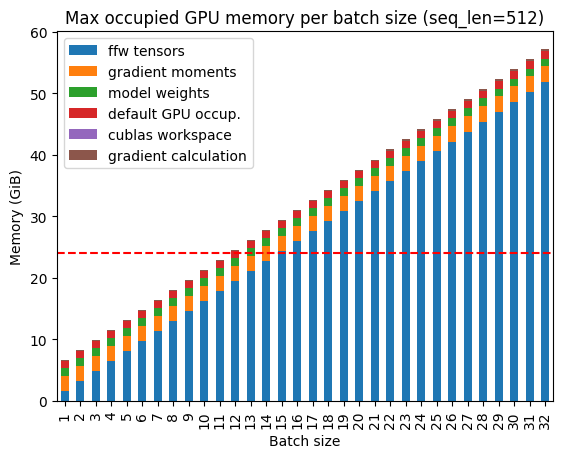

In [24]:
batch_sizes = list(range(1, 33))
# batch_sizes = [1,2,4,8,16,32]
seq_len = 512
ffw_tensor_memory_list = \
    [getExpectedTotalMemoryFfwTensors(bs, seq_len, mdl, element_size) / 1024**3
     for bs in batch_sizes]
temp_grad_calc_memory_list = \
    [getTempGradientCalculationMemory(bs, seq_len, mdl, element_size) / 1024**3
     for bs in batch_sizes]
data = {"ffw tensors": ffw_tensor_memory_list,
        "gradient moments":
            [expected_memory_gradient_moments / 1024**3] * len(batch_sizes),
        "model weights":
            [expected_memory_model_weights / 1024**3] * len(batch_sizes),
        "default GPU occup.":
            [default_gpu_occupation / 1024**3] * len(batch_sizes),
        "cublas workspace":
            [2 * cublas_workspace_size / 1024**3] * len(batch_sizes),
        "gradient calculation": temp_grad_calc_memory_list}
weightsPerBatchSize = pd.DataFrame(data, index=batch_sizes)
# Create a stacked bar chart
ax = weightsPerBatchSize.plot(kind='bar', stacked=True)
# Adding max GPU memory as horizontal line
max_gpu_memory = torch.cuda.mem_get_info()[1] / 1024**3
ax.axhline(y=max_gpu_memory, color='red', linestyle='--')
# Adding titles and labels
plt.title(f"Max occupied GPU memory per batch size (seq_len={seq_len})")
plt.xlabel('Batch size')
plt.ylabel('Memory (GiB)')
plt.show()

Please note, the red dashed line represents the GPU's maximum memory capacity, which in my instance is 24 GiB. Your GPU's capacity may vary. Our analysis indicates that the largest batch size permissible for fine-tuning the BERT-large model with a sequence length of 512 is 11. You are encouraged to verify this finding with your own setup. We also see that the memory requirements (driven by the feedforward tensors) increase linearly with the batch size.

Next, we do the same analysis, but this time varying the sequence length and setting the batch size to 16:

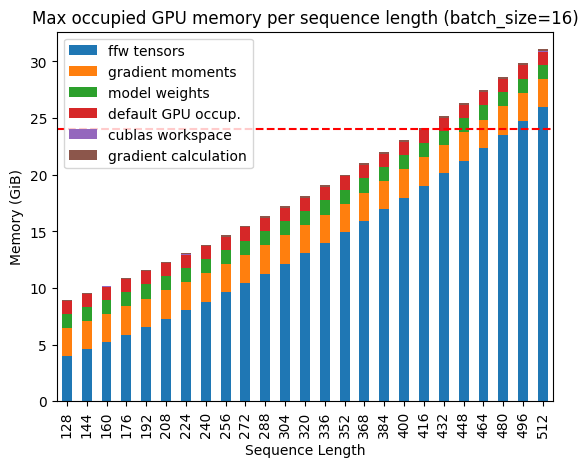

In [25]:
batch_size = 16
sequence_lengths = list(range(128, 513, 16))
# sequence_lengths = [16,32,64,128, 256, 512]
ffw_tensor_memory_list = \
    [getExpectedTotalMemoryFfwTensors(batch_size, sl, mdl, element_size) /
     1024**3 for sl in sequence_lengths]
temp_grad_calc_memory_list = \
    [getTempGradientCalculationMemory(batch_size, sl, mdl, element_size) /
     1024**3 for sl in sequence_lengths]
data = {"ffw tensors": ffw_tensor_memory_list,
        "gradient moments":
            [expected_memory_gradient_moments /
                1024**3] * len(sequence_lengths),
        "model weights":
            [expected_memory_model_weights / 1024**3] * len(sequence_lengths),
        "default GPU occup.":
            [default_gpu_occupation / 1024**3] * len(sequence_lengths),
        "cublas workspace":
            [2 * cublas_workspace_size / 1024**3] * len(sequence_lengths),
        "gradient calculation": temp_grad_calc_memory_list}
weightsPerSequenceLength = pd.DataFrame(data, index=sequence_lengths)
# Create a stacked bar chart
ax = weightsPerSequenceLength.plot(kind='bar', stacked=True)
# Adding max GPU memory as horizontal line
max_gpu_memory = torch.cuda.mem_get_info()[1] / 1024**3
ax.axhline(y=max_gpu_memory, color='red', linestyle='--')
# Adding titles and labels
plt.title(f"Max occupied GPU memory per sequence length (batch_size={batch_size})")
plt.xlabel('Sequence Length')
plt.ylabel('Memory (GiB)')
plt.show()

Our findings reveal that the maximum sequence length achievable with a batch size of 16 is 416. Unlike the linear growth observed with batch size adjustments, we witness an exponential surge in GPU memory consumption as sequence length increases. This trend underscores the inherent quadratic complexity associated with expanding the context size in transformer models. The traditional transformer-style attention mechanism, which compares every token with every other token, is the primary contributor to this increased computational demand.

In conclusion, we will explore various combinations of batch sizes and sequence lengths to understand how they accommodate the available memory constraints:

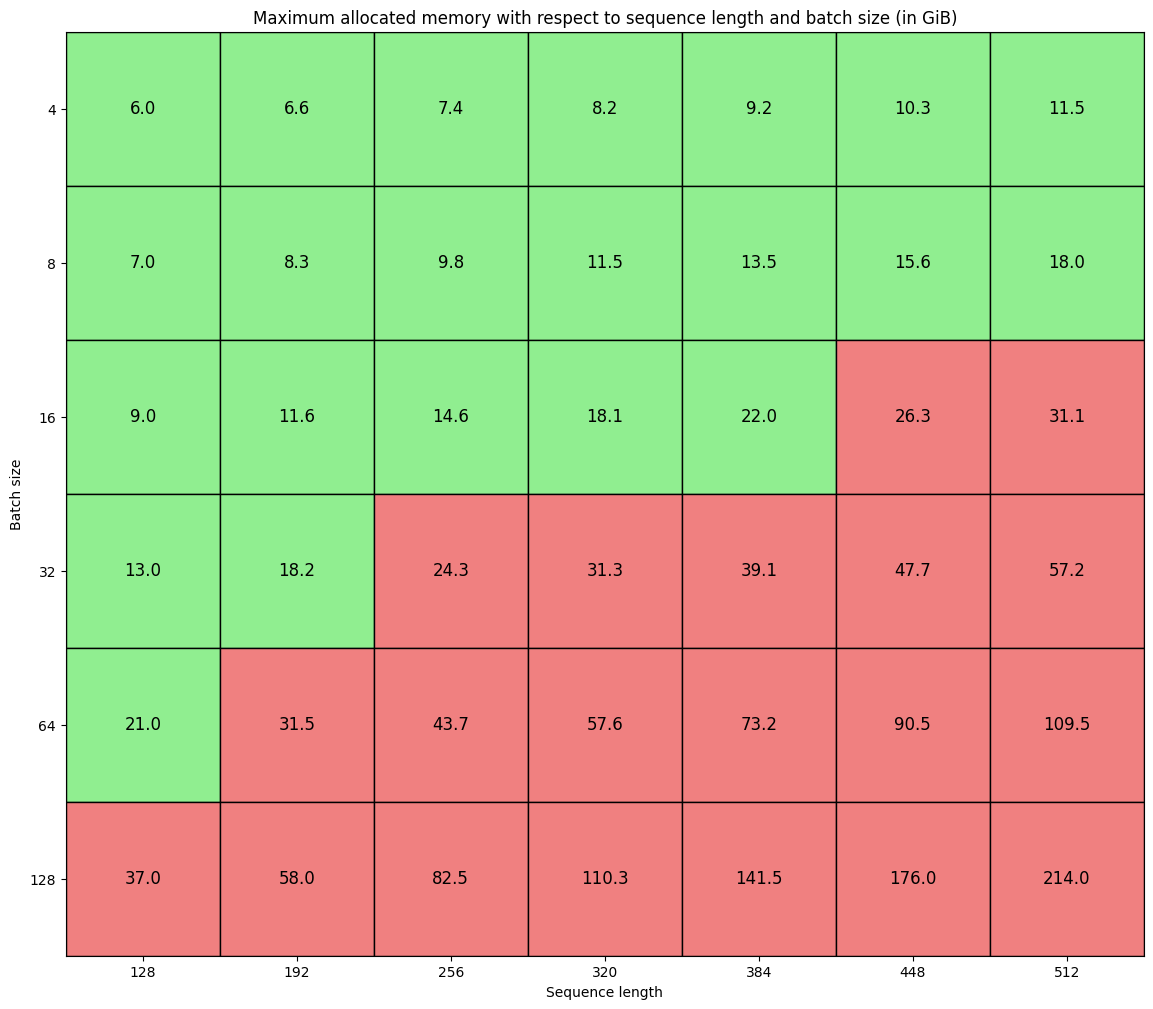

In [26]:
batch_sizes = [4, 8, 16, 32, 64, 128]
sequence_lengths = list(range(128, 513, 64))
max_memory_lists = \
    [
        [
            getExpectedMaximumAllocatedMemory(bs,
                                              sl,
                                              mdl,
                                              element_size,
                                              expected_memory_model_weights,
                                              cublas_workspace_size) / 1024**3
            for sl in sequence_lengths]
        for bs in batch_sizes]
max_memory_lists = pd.DataFrame(
    max_memory_lists,
    index=batch_sizes,
    columns=sequence_lengths)
# Add efault GPU occupation
max_memory_lists += default_gpu_occupation / 1024**3
threshold = torch.cuda.mem_get_info()[1] / 1024**3

# Function to create the plot with squares,
# including boundary lines and axis labels

def create_enhanced_square_plot(df, threshold, xlabels, ylabels):
    # Determine the size of the plot grid
    nrows, ncols = df.shape

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(ncols * 2, nrows * 2))

    # Loop through the data and create a square for each cell
    for i in range(nrows):
        for j in range(ncols):
            # Determine the color based on the threshold
            color = 'lightgreen' if df.iloc[i,
                                            j] <= threshold else 'lightcoral'

            # Create a square with a border
            square = patches.Rectangle(
                (j, nrows - i - 1), 1, 1, facecolor=color, edgecolor='black')

            # Add the square to the plot
            ax.add_patch(square)

            # Add the text in the middle of the square
            text = round(df.iloc[i, j], 1)
            ax.text(j + 0.5, nrows - i - 0.5, text,
                    ha='center', va='center', fontsize=12)

    # Set the limits and aspect of the plot
    ax.set_xlim(0, ncols)
    ax.set_ylim(0, nrows)
    ax.set_aspect('equal')

    # Add axis labels
    ax.set_xticks([0.5 + i for i in range(ncols)])
    ax.set_xticklabels(xlabels)
    ax.set_yticks([0.5 + i for i in range(nrows)])
    ax.set_yticklabels(ylabels[::-1])
    ax.set_xlabel("Sequence length")
    ax.set_ylabel("Batch size")

    # Set title
    ax.set_title(
        "Maximum allocated memory with respect to "
        "sequence length and batch size (in GiB)")
    # Show the plot
    plt.show()
    
# Apply the function to the example DataFrame
create_enhanced_square_plot(
    max_memory_lists, threshold, sequence_lengths, batch_sizes)

For our final analysis, we will examine which feedforward tensor has the largest memory footprint:

In [27]:
def memoryPerFfwTensor(batch_size, seq_len, model, element_size):
    expected_memory_per_ffw_tensor = pd.Series(
        getExpectedMemoryPerFfwTensor(batch_size,
                                      seq_len,
                                      model,
                                      element_size)
    )
    # Only consider one encoder layer
    expected_memory_per_ffw_tensor.index = \
        expected_memory_per_ffw_tensor.index.str.replace("layer_0", "layer")
    expected_memory_per_ffw_tensor = \
        expected_memory_per_ffw_tensor[
            ~expected_memory_per_ffw_tensor.index.str.contains(r"layer_\d")
        ]
    # Sort
    expected_memory_per_ffw_tensor.sort_values(ascending=False, inplace=True)
    # Add relative size
    expected_memory_per_ffw_tensor = pd.DataFrame(
        {"Absolute Size":
         expected_memory_per_ffw_tensor / 1024,
         "Relative Size":
         expected_memory_per_ffw_tensor / expected_memory_per_ffw_tensor.sum(),
         })
    # Add cumulated values
    expected_memory_per_ffw_tensor["Cumulated"] = \
        expected_memory_per_ffw_tensor["Relative Size"].cumsum()
    return expected_memory_per_ffw_tensor

In [28]:
expected_memory_per_ffw_tensor = memoryPerFfwTensor(
    batch_size, seq_len, mdl, element_size)
# Convert to percentage format
expected_memory_per_ffw_tensor[["Relative Size", "Cumulated"]] = \
    expected_memory_per_ffw_tensor[["Relative Size", "Cumulated"]].map(
        lambda x: f'{x:.2%}')
print(expected_memory_per_ffw_tensor)

                                         Absolute Size Relative Size Cumulated
layer_attention_self_probs                 262144.0000        21.76%    21.76%
layer_attention_self_scores                262144.0000        21.76%    43.52%
layer_intermediate_gelu                    131072.0000        10.88%    54.40%
layer_intermediate_dense                   131072.0000        10.88%    65.28%
layer_attention_self_probs_dropout          65536.0000         5.44%    70.72%
layer_output_dense                          32768.0000         2.72%    73.44%
layer_attention_output_layer_norm           32768.0000         2.72%    76.16%
embeddings_add                              32768.0000         2.72%    78.88%
layer_attention_output_dense                32768.0000         2.72%    81.60%
layer_attention_self_context                32768.0000         2.72%    84.32%
layer_output_layer_norm                     32768.0000         2.72%    87.04%
layer_attention_self_value_dense            32768.00

Our analysis reveals that the self-attention tensors, due to their quadratic complexity, consume the most memory, accounting for over 40% of the total. They are followed by the feed-forward tensors, particularly those with intermediate-size embeddings. Notably, increasing the sequence length further amplifies the memory demand of these self-attention layers.

## Final Thoughts

I've designed the BERT training script to be highly adaptable, enabling experimentation with various [established techniques](https://huggingface.co/docs/transformers/v4.18.0/en/performance) aimed at minimizing memory consumption during training, such as:
- Gradient accumulation
- Gradient checkpointing
- Training with FP16 precision

This methodology is not limited to BERT and can be seamlessly extended to other transformer-based models, including language models like [Mistral](https://huggingface.co/mistralai/Mistral-7B-v0.1) or [Phi-2](https://huggingface.co/microsoft/phi-2).

I welcome any feedback, critiques, or suggestions you might have!

With that, we conclude this blog post. Thank you for your time and interest. I look forward to our next encounter!